In [1]:
import numpy as np
import sys
import glob 
import os 
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import scipy.io as sio

import tifffile as tiff

from  tifffile  import  TiffWriter




def DFF(stack,nframes,bframes,Lx,Ly):

    baselineVideo = np.zeros((bframes,Lx,Ly), dtype=np.double)
    DFFtrialVideo = np.zeros((nframes,Lx,Ly), dtype=np.double)
    
    for n in range(bframes):
        baselineVideo[n,:,:] = np.asarray(stack[n,:,:],dtype=np.double)
        
    meanImg =np.mean(baselineVideo, axis = 0)
    
    for n in range(nframes):
        DFFtrialVideo[n,:,:] = np.divide(np.subtract(stack[n,:,:],meanImg),meanImg)
    
    
    return DFFtrialVideo;  


nframes = 211
bframes = 60
mouseName = 'GF218'

#Path = str(Path('D:\Foustoukos\GF193\GF193_20062019\suite2p\ops1.npy'))


datapath = '\\\\sv1files.epfl.ch\\Petersen-Lab\\data\\' + mouseName + '\\Recordings\\Imaging\\'
behavpath = '\\\\sv1files.epfl.ch\\Petersen-Lab\\data\\' + mouseName + '\\Recordings\\BehaviourFiles\\'
localpath = 'D:\\Foustoukos\\' + mouseName + '\\'

print('Reading raw data from : ' + datapath)
print('Reading processed data from : ' + localpath)
    
imaging_days = glob.glob(os.path.join(datapath, "GF*"))

for n,f in enumerate(imaging_days):
    imaging_days[n] = os.path.basename(f)
       
print(len(imaging_days))
    
for i in range(len(imaging_days)):
    
    numOfFrames =[]
    performance =[]
    
    print('Calculating day : ' + imaging_days[i])
    
    #read the ops1 for this day

    ops_path = localpath + imaging_days[i] + '\\suite2p\\'   

    ops_name= glob.glob(os.path.join(ops_path, "ops1*"))

    for n,f in enumerate(ops_name):
        ops_name[n] = os.path.basename(f)

    ops_path_load = ops_path + ops_name[0]

    ops = np.load(ops_path_load,allow_pickle=True).item()

    #read the frame numbers for this day 
    frames_path = datapath + imaging_days[i] + '\\TrialFrames.mat'

    frames = sio.loadmat(frames_path)
    

    numOfFrames = frames['NumOfFrames']
    

    numOfFrames = np.array(numOfFrames)

    #read the behaviour results for this day
    behav_path = behavpath + imaging_days[i] + '\\BehavResults.mat'

    print(behav_path)

    beh = sio.loadmat(behav_path)

    vals = beh['BehavResults'][0,0]

    keys = beh['BehavResults'][0,0].dtype.descr

    beh = np.array(vals[keys[0][0]][:][:])

    performance = beh[:,9]
    
    if imaging_days[i] == 'GF216_25112019':
        
        performance = np.delete(performance,0)
        print('Error for mouse GF216 corrected')
    
    print(len(performance))

    WM = np.array([])
    WH = np.array([])
    AH = np.array([])
    AM = np.array([])
    FA = np.array([])
    CR = np.array([])

    for m in range(len(numOfFrames)):

        if performance[m] == 0.0:
            WM = np.append(WM,np.sum(numOfFrames[0:m]))
        elif performance[m] == 1.0:
            AM = np.append(AM,np.sum(numOfFrames[0:m]))
        elif performance[m] == 2.0:
            WH = np.append(WH,np.sum(numOfFrames[0:m]))
        elif performance[m] == 3.0:
            AH = np.append(AH,np.sum(numOfFrames[0:m]))
        elif performance[m] == 4.0:
            CR = np.append(CR,np.sum(numOfFrames[0:m]))
        elif performance[m] == 5.0:
            FA = np.append(FA,np.sum(numOfFrames[0:m]))
            



    Lx = ops['Lx']
    Ly = ops['Ly']


    #for WMiss
    with open(ops['reg_file'], 'rb') as binary_file:

        nbytestoread = 2*Lx*Ly

        WM_mean_movie = np.zeros((nframes, Ly, Lx), dtype = 'int16')
        WM_mean_movieDFF = np.zeros((nframes, Ly, Lx), dtype = 'int16')
        
        print('Calculating WM')

        for cframe in range(nframes):

            frame_seq = np.zeros((len(WM), Ly, Lx), dtype = 'int16')

            for fr in range(len(WM)):

                bytes = int(nbytestoread*(WM[fr] + cframe))

                binary_file.seek(bytes,0)
                buff = binary_file.read(nbytestoread)
                frame = np.reshape(np.frombuffer(buff, dtype = np.int16, offset = 0),(Ly,Lx))
                frame_seq[fr,:,:] = frame

            meanframe = np.mean(frame_seq, axis = 0)

            WM_mean_movie[cframe,:,:] = meanframe

    WM_mean_movieDFF = DFF(WM_mean_movie,nframes,bframes,Lx,Ly)

    savepath = localpath + imaging_days[i] + '\\suite2p\\' 

    finalpathWM = savepath + imaging_days[i] + '_' + 'WM.tiff'
    finalpathWMDFF = savepath + imaging_days[i] + '_' + 'WM_DFF.tiff'


    with TiffWriter(finalpathWM, bigtiff=True) as tif:

        tif.save(WM_mean_movie, photometric='minisblack')

    with TiffWriter(finalpathWMDFF, bigtiff=True) as tif:

        tif.save(WM_mean_movieDFF, photometric='minisblack')
        
      #for WHit
    with open(ops['reg_file'], 'rb') as binary_file:

        nbytestoread = 2*Lx*Ly

        WH_mean_movie = np.zeros((nframes, Ly, Lx), dtype = 'int16')
        WH_mean_movieDFF = np.zeros((nframes, Ly, Lx), dtype = 'int16')
        
        print('Calculating WH')

        for cframe in range(nframes):

            frame_seq = np.zeros((len(WH), Ly, Lx), dtype = 'int16')

            for fr in range(len(WH)):

                bytes = int(nbytestoread*(WH[fr] + cframe))

                binary_file.seek(bytes,0)
                buff = binary_file.read(nbytestoread)
                frame = np.reshape(np.frombuffer(buff, dtype = np.int16, offset = 0),(Ly,Lx))
                frame_seq[fr,:,:] = frame

            meanframe = np.mean(frame_seq, axis = 0)

            WH_mean_movie[cframe,:,:] = meanframe

    WH_mean_movieDFF = DFF(WH_mean_movie,nframes,bframes,Lx,Ly)

    savepath = localpath + imaging_days[i] + '\\suite2p\\' 

    finalpathWH = savepath + imaging_days[i] + '_' + 'WH.tiff'
    finalpathWHDFF = savepath + imaging_days[i] + '_' + 'WH_DFF.tiff'


    with TiffWriter(finalpathWH, bigtiff=True) as tif:

        tif.save(WH_mean_movie, photometric='minisblack')

    with TiffWriter(finalpathWHDFF, bigtiff=True) as tif:

        tif.save(WH_mean_movieDFF, photometric='minisblack')
        
          #for AMiss
    with open(ops['reg_file'], 'rb') as binary_file:

        nbytestoread = 2*Lx*Ly

        AM_mean_movie = np.zeros((nframes, Ly, Lx), dtype = 'int16')
        AM_mean_movieDFF = np.zeros((nframes, Ly, Lx), dtype = 'int16')
        
        print('Calculating AM')

        for cframe in range(nframes):

            frame_seq = np.zeros((len(AM), Ly, Lx), dtype = 'int16')

            for fr in range(len(AM)):

                bytes = int(nbytestoread*(AM[fr] + cframe))

                binary_file.seek(bytes,0)
                buff = binary_file.read(nbytestoread)
                frame = np.reshape(np.frombuffer(buff, dtype = np.int16, offset = 0),(Ly,Lx))
                frame_seq[fr,:,:] = frame

            meanframe = np.mean(frame_seq, axis = 0)

            AM_mean_movie[cframe,:,:] = meanframe

    AM_mean_movieDFF = DFF(AM_mean_movie,nframes,bframes,Lx,Ly)

    savepath = localpath + imaging_days[i] + '\\suite2p\\' 

    finalpathAM = savepath + imaging_days[i] + '_' + 'AM.tiff'
    finalpathAMDFF = savepath + imaging_days[i] + '_' + 'AM_DFF.tiff'


    with TiffWriter(finalpathAM, bigtiff=True) as tif:

        tif.save(AM_mean_movie, photometric='minisblack')

    with TiffWriter(finalpathAMDFF, bigtiff=True) as tif:

        tif.save(AM_mean_movieDFF, photometric='minisblack')
        
          
          #for AHit
    with open(ops['reg_file'], 'rb') as binary_file:

        nbytestoread = 2*Lx*Ly

        AH_mean_movie = np.zeros((nframes, Ly, Lx), dtype = 'int16')
        AH_mean_movieDFF = np.zeros((nframes, Ly, Lx), dtype = 'int16')
        
        print('Calculating AH')

        for cframe in range(nframes):

            frame_seq = np.zeros((len(AH), Ly, Lx), dtype = 'int16')

            for fr in range(len(AH)):

                bytes = int(nbytestoread*(AH[fr] + cframe))

                binary_file.seek(bytes,0)
                buff = binary_file.read(nbytestoread)
                frame = np.reshape(np.frombuffer(buff, dtype = np.int16, offset = 0),(Ly,Lx))
                frame_seq[fr,:,:] = frame

            meanframe = np.mean(frame_seq, axis = 0)

            AH_mean_movie[cframe,:,:] = meanframe

    AH_mean_movieDFF = DFF(AH_mean_movie,nframes,bframes,Lx,Ly)

    savepath = localpath + imaging_days[i] + '\\suite2p\\' 

    finalpathAH = savepath + imaging_days[i] + '_' + 'AH.tiff'
    finalpathAHDFF = savepath + imaging_days[i] + '_' + 'AH_DFF.tiff'


    with TiffWriter(finalpathAH, bigtiff=True) as tif:

        tif.save(AH_mean_movie, photometric='minisblack')

    with TiffWriter(finalpathAHDFF, bigtiff=True) as tif:

        tif.save(AH_mean_movieDFF, photometric='minisblack')
        
            #for CR
    with open(ops['reg_file'], 'rb') as binary_file:

        nbytestoread = 2*Lx*Ly

        CR_mean_movie = np.zeros((nframes, Ly, Lx), dtype = 'int16')
        CR_mean_movieDFF = np.zeros((nframes, Ly, Lx), dtype = 'int16')
        
        print('Calculating CR')

        for cframe in range(nframes):

            frame_seq = np.zeros((len(CR), Ly, Lx), dtype = 'int16')

            for fr in range(len(CR)):

                bytes = int(nbytestoread*(CR[fr] + cframe))

                binary_file.seek(bytes,0)
                buff = binary_file.read(nbytestoread)
                frame = np.reshape(np.frombuffer(buff, dtype = np.int16, offset = 0),(Ly,Lx))
                frame_seq[fr,:,:] = frame

            meanframe = np.mean(frame_seq, axis = 0)

            CR_mean_movie[cframe,:,:] = meanframe

    CR_mean_movieDFF = DFF(CR_mean_movie,nframes,bframes,Lx,Ly)

    savepath = localpath + imaging_days[i] + '\\suite2p\\' 

    finalpathCR = savepath + imaging_days[i] + '_' + 'CR.tiff'
    finalpathCRDFF = savepath + imaging_days[i] + '_' + 'CR_DFF.tiff'


    with TiffWriter(finalpathCR, bigtiff=True) as tif:

        tif.save(CR_mean_movie, photometric='minisblack')

    with TiffWriter(finalpathCRDFF, bigtiff=True) as tif:

        tif.save(CR_mean_movieDFF, photometric='minisblack')
        
             #for FA
    with open(ops['reg_file'], 'rb') as binary_file:

        nbytestoread = 2*Lx*Ly

        FA_mean_movie = np.zeros((nframes, Ly, Lx), dtype = 'int16')
        FA_mean_movieDFF = np.zeros((nframes, Ly, Lx), dtype = 'int16')
        
        print('Calculating FA')

        for cframe in range(nframes):

            frame_seq = np.zeros((len(FA), Ly, Lx), dtype = 'int16')

            for fr in range(len(FA)):

                bytes = int(nbytestoread*(FA[fr] + cframe))

                binary_file.seek(bytes,0)
                buff = binary_file.read(nbytestoread)
                frame = np.reshape(np.frombuffer(buff, dtype = np.int16, offset = 0),(Ly,Lx))
                frame_seq[fr,:,:] = frame

            meanframe = np.mean(frame_seq, axis = 0)

            FA_mean_movie[cframe,:,:] = meanframe

    FA_mean_movieDFF = DFF(FA_mean_movie,nframes,bframes,Lx,Ly)

    savepath = localpath + imaging_days[i] + '\\suite2p\\' 

    finalpathFA = savepath + imaging_days[i] + '_' + 'FA.tiff'
    finalpathFADFF = savepath + imaging_days[i] + '_' + 'FA_DFF.tiff'


    with TiffWriter(finalpathFA, bigtiff=True) as tif:

        tif.save(FA_mean_movie, photometric='minisblack')

    with TiffWriter(finalpathFADFF, bigtiff=True) as tif:

        tif.save(FA_mean_movieDFF, photometric='minisblack')







Reading raw data from : \\sv1files.epfl.ch\Petersen-Lab\data\GF218\Recordings\Imaging\
Reading processed data from : D:\Foustoukos\GF218\
6
Calculating day : GF218_26112019
\\sv1files.epfl.ch\Petersen-Lab\data\GF218\Recordings\BehaviourFiles\GF218_26112019\BehavResults.mat
501
Calculating WM
Calculating WH
Calculating AM
Calculating AH
Calculating CR
Calculating FA
Calculating day : GF218_28112019
\\sv1files.epfl.ch\Petersen-Lab\data\GF218\Recordings\BehaviourFiles\GF218_28112019\BehavResults.mat
547
Calculating WM
Calculating WH
Calculating AM
Calculating AH
Calculating CR
Calculating FA
Calculating day : GF218_22112019
\\sv1files.epfl.ch\Petersen-Lab\data\GF218\Recordings\BehaviourFiles\GF218_22112019\BehavResults.mat
417
Calculating WM
Calculating WH


C:\Users\foustouk\.conda\envs\suite2p\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\foustouk\.conda\envs\suite2p\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\foustouk\.conda\envs\suite2p\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


Calculating AM
Calculating AH
Calculating CR
Calculating FA
Calculating day : GF218_23112019
\\sv1files.epfl.ch\Petersen-Lab\data\GF218\Recordings\BehaviourFiles\GF218_23112019\BehavResults.mat
363
Calculating WM
Calculating WH
Calculating AM
Calculating AH
Calculating CR
Calculating FA
Calculating day : GF218_24112019
\\sv1files.epfl.ch\Petersen-Lab\data\GF218\Recordings\BehaviourFiles\GF218_24112019\BehavResults.mat
437
Calculating WM
Calculating WH
Calculating AM
Calculating AH
Calculating CR
Calculating FA
Calculating day : GF218_25112019
\\sv1files.epfl.ch\Petersen-Lab\data\GF218\Recordings\BehaviourFiles\GF218_25112019\BehavResults.mat
548
Calculating WM
Calculating WH
Calculating AM
Calculating AH
Calculating CR
Calculating FA


In [2]:
import numpy as np
import sys
import glob 
import os 
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import scipy.io as sio

import tifffile as tiff

from  tifffile  import  TiffWriter


(211, 512, 512)


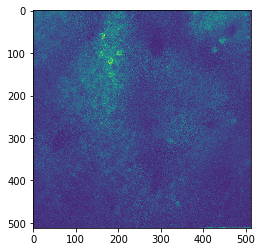

In [9]:
import tifffile as tiff    

def DFF(stack,nframes,bframes,Lx,Ly)

    baselineVideo = np.zeros((bframes,Lx,Ly), dtype=np.double)
    DFFtrialVideo = np.zeros((nframes,Lx,Ly), dtype=np.double)
    
    for n in range(bframs):
        baselineVideo[n,:,:] = np.asarray(stack[n,:,:],dtype=np.double)
        
    meanImg =np.mean(baselineVideo, axis = 0)
    
    for n in range(nframes):
        DFFtrialVideo[n,:,:] = np.divide(np.subtract(stack[n,:,:],meanImg),meanImg)
        
    return DFFtrialVideo   

imgStack = tiff.imread('D:\\Foustoukos\\GF193\\GF193_20062019\\suite2p\\test.tif')

print(imgStack.shape)
img 
#plt.figure()
#imgplot = plt.imshow(imgStack[1,:,:])

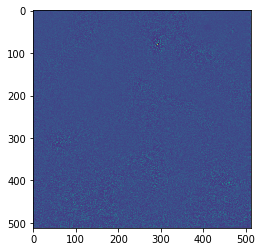

In [41]:
from  tifffile  import  TiffWriter

imgStack = tiff.imread('D:\\Foustoukos\\GF193\\GF193_20062019\\suite2p\\test.tif')
bframes = 60
nframes = 211
baselineVideo = np.zeros((60,512,512), dtype=np.double)
DFFtrialVideo = np.zeros((211,512,512), dtype=np.double)
    
for n in range(bframes):
    baselineVideo[n,:,:] = np.asarray(imgStack[n,:,:],dtype=np.double)
    
meanImg =np.mean(baselineVideo, axis = 0)


for n in range(nframes):
    DFFtrialVideo[n,:,:] =  np.divide(np.subtract(imgStack[n,:,:],meanImg),meanImg)

#print(meanImg.shape)
#print(baselineVideo)
plt.figure()
imgplot = plt.imshow(DFFtrialVideo[10,:,:])

with TiffWriter('D:\\Foustoukos\\GF193\\GF193_20062019\\suite2p\\testDF.tif', bigtiff=True) as tif:
    
      tif.save(DFFtrialVideo, photometric='minisblack')



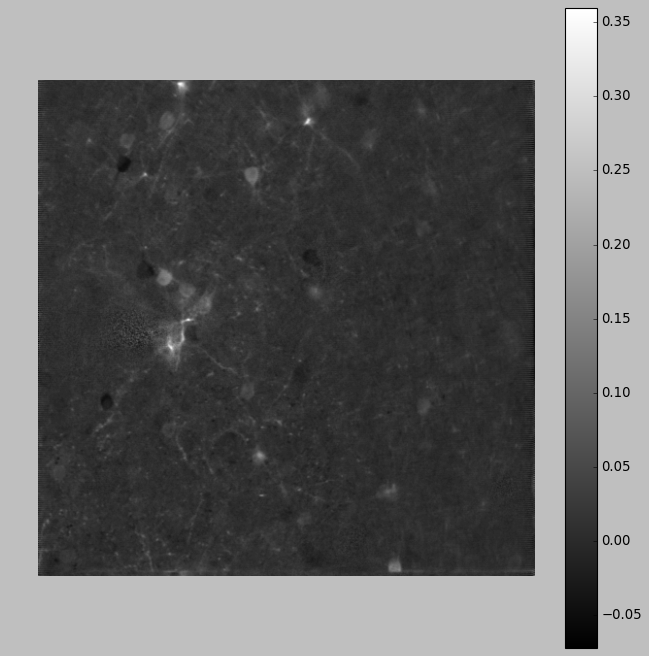

In [22]:

fig = plt.figure(figsize=(10, 10))
#pos = ax.imshow(Zpos, cmap='gray', interpolation='none')
Image = tiff.imread('D:\\WHA.tif')
imgplot = plt.imshow(Image)
plt.axis('off')
plt.colorbar()

<Figure size 432x288 with 0 Axes>

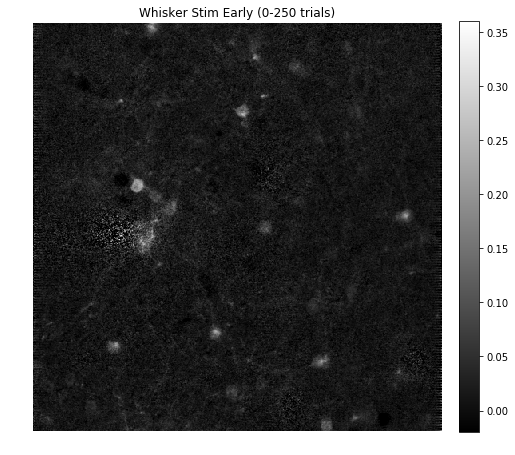

In [5]:
plt.gray()
fig = plt.figure(figsize=(8, 8))
fig.patch.set_facecolor('xkcd:white')
ax = plt.gca()
#pos = ax.imshow(Zpos, cmap='gray', interpolation='none')
Image = tiff.imread('D:\\WSTIME.tif')
imgplot = plt.imshow(Image)
plt.axis('off')
plt.colorbar(imgplot,fraction=0.046, pad=0.04)
plt.title('Whisker Stim Early (0-250 trials)')
plt.clim(-0.02,0.36)
fig.savefig('D:\\WSTIME.png',format='png', dpi=1000)

In [44]:
np.max(Image)

0.28891382

In [127]:
import scipy.io as sio

mouseName = 'GF193'


datapath = '\\\\sv1files.epfl.ch\\Petersen-Lab\\data\\' + mouseName + '\\Recordings\\Imaging\\'
localpath = 'D:\\Foustoukos\\' + mouseName + '\\'

print('Reading raw data from : ' + datapath)
print('Reading processed data from : ' + localpath)
    
imaging_days = glob.glob(os.path.join(datapath, "GF*"))

for n,f in enumerate(imaging_days):
    imaging_days[n] = os.path.basename(f)
    

ops_path = localpath + imaging_days[1] + '\\suite2p\\'
    
ops_name_load = glob.glob(os.path.join(ops_path, "ops1*"))

  
for n,f in enumerate(ops_name_load):
    ops_name[n] = os.path.basename(f)

ops_path_load  = ops_path + '\\' + ops_name[0]
    
ops = np.load(ops_path_load,allow_pickle=True).item

frames_path = datapath + imaging_days[1] + '\\TrialFrames.mat'

behaviour_path = 'M:\\data\\GF193\\Recordings\\BehaviourFiles\\GF193_20062019\\BehavResults.mat'

beh = sio.loadmat(behaviour_path)

vals = beh['BehavResults'][0,0]
    
keys = beh['BehavResults'][0,0].dtype.descr
    
beh = np.array(vals[keys[0][0]][:][:])
    
performance = beh[:,9]


print(performance)


Reading raw data from : \\sv1files.epfl.ch\Petersen-Lab\data\GF193\Recordings\Imaging\
Reading processed data from : D:\Foustoukos\GF193\
[4. 3. 6. 3. 5. 6. 4. 3. 4. 6. 3. 6. 3. 3. 6. 6. 6. 6. 6. 6. 6. 5. 5. 6.
 3. 6. 6. 6. 3. 6. 5. 4. 6. 6. 3. 6. 6. 6. 6. 3. 5. 6. 6. 6. 6. 6. 6. 6.
 6. 4. 6. 6. 6. 6. 5. 6. 6. 6. 3. 6. 6. 4. 6. 3. 6. 6. 6. 6. 6. 6. 6. 6.
 5. 3. 6. 6. 6. 1. 6. 6. 6. 6. 6. 4. 6. 4. 6. 4. 6. 6. 3. 6. 3. 6. 3. 6.
 6. 4. 6. 5. 3. 3. 6. 6. 3. 6. 6. 4. 4. 6. 3. 6. 4. 6. 6. 6. 6. 4. 6. 6.
 3. 6. 6. 6. 5. 6. 3. 6. 6. 4. 3. 6. 6. 4. 6. 4. 6. 6. 3. 3. 3. 4. 4. 6.
 3. 3. 6. 6. 6. 6. 3. 6. 6. 6. 5. 6. 6. 4. 6. 4. 6. 6. 3. 6. 6. 6. 6. 3.
 6. 5. 6. 4. 6. 6. 3. 6. 6. 3. 6. 6. 6. 6. 6. 6. 6. 6. 6. 4. 4. 6. 5. 3.
 3. 6. 3. 5. 6. 6. 6. 3. 6. 6. 6. 4. 3. 6. 3. 4. 6. 6. 6. 6. 4. 6. 6. 6.
 6. 4. 6. 6. 4. 6. 6. 3. 6. 3. 5. 6. 3. 6. 5. 6. 3. 6. 5. 6. 6. 3. 6. 6.
 6. 3. 5. 6. 5. 3. 6. 6. 6. 6. 6. 4. 6. 3. 6. 6. 6. 6. 5. 6. 6. 6. 4. 6.
 6. 6. 3. 6. 3. 6. 3. 6. 4. 3. 6. 5. 6. 5. 6. 6. 6. 3. 6. 6

In [43]:
Image

array([[-2.93085584e-03,  8.79929308e-03,  1.22811329e-02, ...,
        -2.37186346e-02, -4.16080281e-03,  5.38223311e-02],
       [-3.87308327e-03,  2.14379723e-03, -1.72472536e-03, ...,
         5.50964056e-03,  1.26253860e-02,  1.13470815e-02],
       [ 3.98199372e-02,  2.93174721e-02,  3.37518267e-02, ...,
         1.02777397e-02,  2.56588534e-02,  3.86402383e-02],
       ...,
       [ 4.43318766e-03,  2.79573165e-03,  4.69818769e-05, ...,
        -7.98116787e-04,  4.42319317e-03, -3.10280680e-04],
       [ 1.81594808e-02,  1.52517203e-02,  7.92486593e-03, ...,
         2.03595846e-03,  8.68922099e-03,  1.38718300e-02],
       [-1.97998201e-03,  4.59851418e-03,  5.86952455e-03, ...,
         7.63426349e-03,  6.21146616e-03, -8.57687648e-03]], dtype=float32)

In [7]:
A = np.delete(performance,0)

In [9]:
A.shape

(462,)

In [10]:
performance.shape

(463,)

In [11]:
performance = np.delete(performance,0)

In [12]:
performance.shape

(462,)